# <u>NSW DCCEEW training – Demo 2: basic time series statistics</u>

 - <b>Author</b>: Eric.Lehmann@csiro.au
 - <b>Release date / version</b>: Aug. 2024, v1.0
 - <b>Dev. platform</b>: CSIRO ADIAS/ADS (hub.adias.aquawatchaus.space)
 - <b>Server profile</b>: EASI Open Data Cube No ML &ndash; Version 2023.10.2 
 - <b>Server resources</b>: 32 CPU &ndash; 64GB RAM
 - <b>Python kernel</b>: `Python 3 (ipykernel)`
 - <b>Dask</b>: Local cluster
 

<b>Contents</b>
  - [Overview](#Overview)
  - [User parameters](#User-parameters)
  - [Notebook setup](#Notebook-setup)
  - [Dask](#Dask)
  - [Data loading, pre-processing, TSS calculation](#Data-loading,-pre-processing,-TSS-calculation)
  - [Basic statistics](#Basic-statistics)
    - [Overall mean and coefficient of variation](#Overall-mean-and-coefficient-of-variation)
      - [Built-in Xarray operations](#Built-in-Xarray-operations)
      - [Robust statistics](#Robust-statistics)
    - [Pixel drills](#Pixel-drills)
    - [Hovmöller plots](#Hovmöller-plots)
    - [Time-of-year means over quarters](#Time-of-year-means-over-quarters)
    - [Yearly anomalies](#Yearly-anomalies)
    - [(Robust) temporal trend: OLS model](#(Robust)-temporal-trend:-OLS-model)

# Overview

This series of notebooks (`NSW DCCEEW training`) provides a demonstration of some basic analyses of water quality parameter (TSS) using Landsat data (Acolite processed).

  - Demonstration notebooks
    - For audience with various skills levels
    - Get a feel for EASI / ADIAS and ODC technology
  - Demonstrates some interesting science:
    - Calculation of empirical algorithms for water quality parameters (TSS)
    - Basic statistical and trends analyses
    - Calculation of sediment flux using BoM rainfall data
  - Touches on various technical aspects:
    - JupyterLab environment and notebooks
    - Data availability and access on ADIAS and elsewhere
    - Visualisation
    - Parallelism and parallelised processing
 
# User parameters

In [1]:
### Selected river systems: lat/lon locations
riv_loc =  (151.34428, -33.5677)   # selected location -- river mouth, Haweksbury

min_longitude, max_longitude = (151.1355, 151.7047)   # ROI for visualisation purposes
min_latitude, max_latitude = (-33.8025,-33.3707)

time_range = ('2013-01-01','2025-01-01')   # selected time window: FULL LANDSAT TIME SERIES
# time_range = ('2020-01-01','2025-01-01')   # selected time window: testing

### Selected parameter to plot / visualise 
# Note: various WQ parameters can be theoretically selected for analysis in the code below. However,
# the flux calculations at the end of this notebook will fail for WQ units other than 'mg/L'.
WQparam = 'TSS'          # selected WQ parameter
WQunits = 'mg/L'         # WQ units
lower_is_better = True   # whether lower WQ values are blue/red in plots
wq_log_scale = True      # whether to plot raw WQ values in log-scale

n_workers = None    # for local Dask cluster
# n_workers = 12; workers_mem = 8    # for Dask Gateway cluster

# Notebook setup

In [2]:
### System
import sys, os
import itertools

### Data handling
import pyproj
import numpy as np
import xarray as xr
from astropy.stats import sigma_clip
import statsmodels.api as sm

import rioxarray
import rasterio
import rasterio.features
import geopandas as gpd
import pandas as pd

from shapely.affinity import translate
from shapely.geometry import Polygon
import xml.etree.ElementTree as ET

### ODC / STAC
import odc.stac
import pystac_client

### Data cube
import datacube
dc = datacube.Datacube(app="NSW_demo")

### Dask
from dask.distributed import wait

### Display / plots
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap

Here making use of a couple of functions from the base EASI notebooks &ndash; these can be accessed by `git clone`-ing the following repo: `https://github.com/csiro-easi/easi-notebooks.git`

In [3]:
### Misc
sys.path.append('/home/jovyan/git_hub_notebooks/scripts/')
import notebook_utils   # for xarray_object_size(), localcluster_dashboard()
from app_utils import display_map

# Eric's own function for getting coastline data:
exec(open("./get_coastline.py").read())

In [4]:
if lower_is_better: 
    cmap = 'jet'
    cmap1 = 'RdBu_r'   # 'coolwarm': centre colour is grey -- 'RdBu_r': centre colour is white
else: 
    cmap = 'jet_r'
    cmap1 = 'RdBu'
    
if wq_log_scale: norm = colors.LogNorm()
else: norm = None

cmp = LinearSegmentedColormap.from_list("cmp", ["gainsboro", "gainsboro"])   # "dummy" colormap for greyed out land pixels

In [5]:
import warnings

### Filter out following warnings:
# /env/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 32.04 MiB.
# This may cause some slowdown. Consider scattering data ahead of time and using futures.
warnings.filterwarnings("ignore", category=UserWarning)

# warnings.resetwarnings()

In [6]:
from collections import Counter

def mostcommon_crs_res(dc, query):
    # Returns the most common CRS and resolution for a given DC query.
    # Adapted from 'mostcommon_crs()' from 'notebook_utils'
    """Adapted from https://github.com/GeoscienceAustralia/dea-notebooks/blob/develop/Tools/dea_tools/datahandling.py"""
    matching_datasets = dc.find_datasets(**query)
    crs_list = [str(i.crs) for i in matching_datasets]
    resx_list = [i.metadata_doc['grids']['default']['transform'][0] for i in matching_datasets]   # x-res
    resy_list = [i.metadata_doc['grids']['default']['transform'][4] for i in matching_datasets]   # y-res
    
    crs_mostcommon = None
    res_mostcommon = None
    if len(crs_list) > 0:
        # Identify most common CRS + resolution
        crs_counts = Counter(crs_list)
        crs_mostcommon = crs_counts.most_common(1)[0][0]
        
        resx_counts = Counter(resx_list)
        resy_counts = Counter(resy_list)
        res_mostcommon = (resx_counts.most_common(1)[0][0], resy_counts.most_common(1)[0][0])
    else:
        logger.warning('No data was found for the supplied product query')
    return crs_mostcommon, res_mostcommon

# Dask

Flexible open-source library for parallel and distributed computing in Python. It provides integration with various Python libraries like NumPy, Pandas, and scikit-learn to enable parallel execution across multiple cores.

In [7]:
### Local Dask cluster
if n_workers is None:  # local Dask cluster using all available CPUs
    
    from dask.distributed import Client, LocalCluster
    # sys.path.append('/home/jovyan/git_hub_notebooks/scripts/')
    # import notebook_utils   # for localcluster_dashboard()

    cluster = LocalCluster()
    client = Client(cluster)

    print(f"Local cluster dashboard: {notebook_utils.localcluster_dashboard(client,server='https://hub.adias.aquawatchaus.space')}")
    display(cluster)

### Use the following to shut down this cluster:
# cluster.close()
# client.shutdown()

Local cluster dashboard: https://hub.adias.aquawatchaus.space/user/eric.lehmann/proxy/8787/status


LocalCluster(2f544f41, 'tcp://127.0.0.1:34691', workers=8, threads=32, memory=64.00 GiB)

In [8]:
### Dask Gateway cluster @ n_workers
if n_workers is not None:

    from dask_gateway import Gateway
    gateway = Gateway()
    
    # shutdown_all_clusters...
    clusterRpts = gateway.list_clusters()
    if len(clusterRpts)>0: print(f"Shutting down running clusters:\n {clusterRpts}")
    for cluster in clusterRpts:
        c = gateway.connect(cluster.name)
        c.shutdown()

    print("Creating new Gateway cluster...")

    options = gateway.cluster_options()
    options.node_selection = "worker" 
    options.worker_cores = 8
    options.worker_memory = workers_mem

    cluster = gateway.new_cluster(cluster_options=options)
    cluster.scale(n_workers)
    display( cluster )

    ### Wait for all workers to start
    client = cluster.get_client()
    display( client )
    client.sync( client._wait_for_workers, n_workers=n_workers )

### Use the following to shut down this cluster:
# cluster.shutdown()
# client.close()

In [9]:
display_map(x=(min_longitude,max_longitude), y=(min_latitude,max_latitude))

# Data loading, pre-processing, TSS calculation

Refer to the first notebook in this series (`demo01`) for more info if needed!

Overview of the Landsat data on ADS: https://explorer.adias.aquawatchaus.space/products/landsat8_c2_acolite_ar and https://explorer.adias.aquawatchaus.space/products/landsat9_c2_acolite_ar


In [10]:
LS_band_aliases = ['SR_B1','SR_B3']
chunking = {'x': 512, 'y': 512, 'time': 1}

query = { 'product': ('landsat8_c2_acolite_ar','landsat9_c2_acolite_ar'),    # Landsat products
          'longitude': (min_longitude, max_longitude),    # "x" axis bounds
          'latitude': (min_latitude, max_latitude),      # "y" axis bounds
          'time': time_range,                       # Any parsable date strings
          'group_by': 'solar_day',                # Scene ordering
          'measurements': LS_band_aliases }  # Landsat8/9 bands

mc_crs, mc_res = mostcommon_crs_res(dc, query)   # Landsat datasets' native CRS and resolution
query.update( output_crs=mc_crs, 
              dask_chunks=chunking, 
              resolution=mc_res,
              resampling={'*':'average', 'l2_flags':'nearest'} )   # average resampling leads to least amount of missing pixels
_ = query.pop('product')   # dc.load() not (supposed to be) able to load multiple products...

In [11]:
%%time

data_ls8 = dc.load( product='landsat8_c2_acolite_ar', **query ).persist()
_ = wait(data_ls8)

data_ls9 = dc.load( product='landsat9_c2_acolite_ar', **query ).persist()
_ = wait(data_ls9)

CPU times: user 46.3 s, sys: 3.65 s, total: 49.9 s
Wall time: 5min 56s


In [12]:
### Merge LS8 and LS9 datasets
data = xr.concat([data_ls8, data_ls9], dim="time", compat='identical').sortby("time").persist()
_ = wait(data)

### Apply conversion and empirical WQ algorithms.
data = data * 1.0301 - 0.00001   # applied to each band
data = data.where(data>0)   # filter out negative SR values

data['TSS'] = 1.1486 * pow(data.SR_B3 / data.SR_B1, 0.7053)

### Remove SR bands (not required any longer)
data = data.drop(LS_band_aliases).persist()

### Remove any time slice that only contains NaNs
data = data.dropna('time',how='all').persist()
_ = wait(data)

tmp = data.time.values
date_start = tmp[0].astype('datetime64[D]')
date_end = tmp[-1].astype('datetime64[D]')

In [13]:
### Generate coastline and land mask for current extents, in projected CRS
tmp = data.TSS[0].rio.reproject('EPSG:4326').rename({'x':'longitude','y':'latitude'})

offset = (-0.006,-0.001)   # fix apparent mis-alignment coastline vs. Landsat (...?!??)
land_mask, shp_poly = get_coastline( ds_lon_vec=tmp.longitude.values, ds_lat_vec=tmp.latitude.values, offset=offset)   #, do_plot=True)#, buf=0.2 )

land_mask.rio.write_crs('EPSG:4326', inplace=True)
land_mask = land_mask.rio.reproject_match( data )
shp_poly = shp_poly.set_crs('EPSG:4326').to_crs(mc_crs)

# Basic statistics

## Overall mean and coefficient of variation

### Built-in Xarray operations

Using standard Xarray operations for overall mean and coefficient of variation...

In [14]:
%%time

### Calculate overall mean and CV
overall_mean = data[['TSS']].mean('time')
overall_cv = data[['TSS']].std('time') / overall_mean

overall_mean = overall_mean.where(land_mask)
overall_mean = overall_mean.rename_vars({'TSS':'TSS_mean'}).persist()
_ = wait(overall_mean)

overall_cv = overall_cv.where(land_mask)
overall_cv = overall_cv.rename_vars({'TSS':'TSS_CV'}).persist()
_ = wait(overall_cv)

/env/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/env/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/env/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/env/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/env/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/env/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


CPU times: user 16.7 s, sys: 411 ms, total: 17.1 s
Wall time: 21 s


/env/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


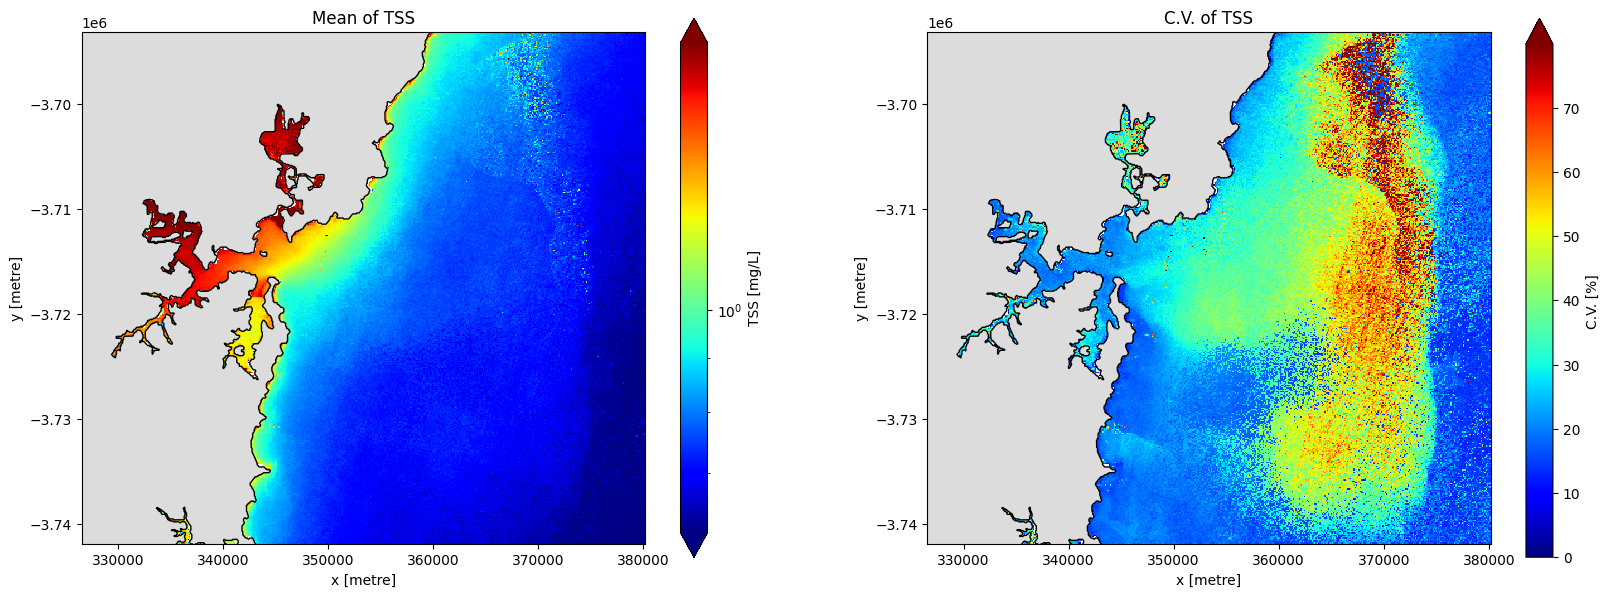

In [15]:
### Plots of results, visual checks
plt_subs = 4   # subsampling increment for plots

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,7))
display( HTML(f'<h4>Overall stats for Landsat-8/9 time series') )

overall_mean['TSS_mean'][::plt_subs,::plt_subs].plot(robust=True, cmap=cmap, norm=norm, cbar_kwargs={'label':f'{WQparam} [{WQunits}]'}, ax=ax1)
ax1.set_title(f"Mean of TSS")
ax1.set_aspect('equal','box')
land_mask[::plt_subs,::plt_subs].plot(ax=ax1, add_colorbar=False, add_labels=False, cmap=cmp)
shp_poly.boundary.plot(ax=ax1, color='black', linewidth=1);

(overall_cv['TSS_CV'][::plt_subs,::plt_subs]*100.).plot(robust=True, cmap="jet", cbar_kwargs={'label':'C.V. [%]'}, ax=ax2)
ax2.set_title(f"C.V. of TSS")
ax2.set_aspect('equal','box')
land_mask[::plt_subs,::plt_subs].plot(ax=ax2, add_colorbar=False, add_labels=False, cmap=cmp)
shp_poly.boundary.plot(ax=ax2, color='black', linewidth=1);

### Robust statistics

Calculate the mean and CV over the entire time series. We here use a robust approach where outliers are first filtered out of the time series data prior to applying the mean and CV.

In [16]:
### Select the WQ of interest and re-chunk the Dask array -- remove time chunking for time-series processing
data_wq = data['TSS'].chunk({'time':-1, 'x':32, 'y':32}).persist()   # DataArray
data_wq

<xarray.DataArray 'TSS' (time: 370, y: 1624, x: 1787)>
dask.array<rechunk-merge, shape=(370, 1624, 1787), dtype=float32, chunksize=(370, 32, 32), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2013-03-27T23:48:16.509468 ... 2023-04...
  * y            (y) float64 -3.742e+06 -3.742e+06 ... -3.693e+06 -3.693e+06
  * x            (x) float64 3.801e+05 3.801e+05 ... 3.266e+05 3.265e+05
    spatial_ref  int32 32656

#### Example using `xr.apply_ufunc` 

Custom processing algorithms (time-series processing in the example below) can be applied in a parallelised fashion to a Dask Xarray object hosted on the workers of the Dask Cluster.

The function `apply_ufunc` can be used to this purpose and provides low-level access to the data (but is also more complex to use as a result). Using this approach, the processing function (`robust_stats` below) receives a Numpy array corresponding to the time series of TSS data at each `x`/`y` pixel, and returns the resulting mean and C.V. 

In [17]:
### for use with xr.apply_ufunc
def robust_stats(dat, n_valid=10):   
    dat = sigma_clip( dat[~np.isnan(dat)], masked=False )   # filter out NaNs and outliers
    if len(dat)<n_valid: return np.array([np.nan, np.nan])   # min 'n_valid' data points
    mm = np.mean(dat)       # mean of data
    cv = np.std(dat) / mm   # CV of data
    return np.array([mm, cv])

In [18]:
%%time

### Calculate robust stats
data_wq_stats = xr.apply_ufunc( robust_stats, data_wq, input_core_dims=[["time"]], 
                                dask='parallelized', vectorize=True, 
                                output_core_dims=[['robust_stats']], output_dtypes=[float],
                                dask_gufunc_kwargs={'output_sizes':{'robust_stats':2}} )

data_wq_stats['robust_stats'] = ['mean', 'cv']   # (re)name outputs
data_wq_stats = data_wq_stats.persist()
_ = wait(data_wq_stats)

CPU times: user 18.6 s, sys: 618 ms, total: 19.2 s
Wall time: 49.2 s


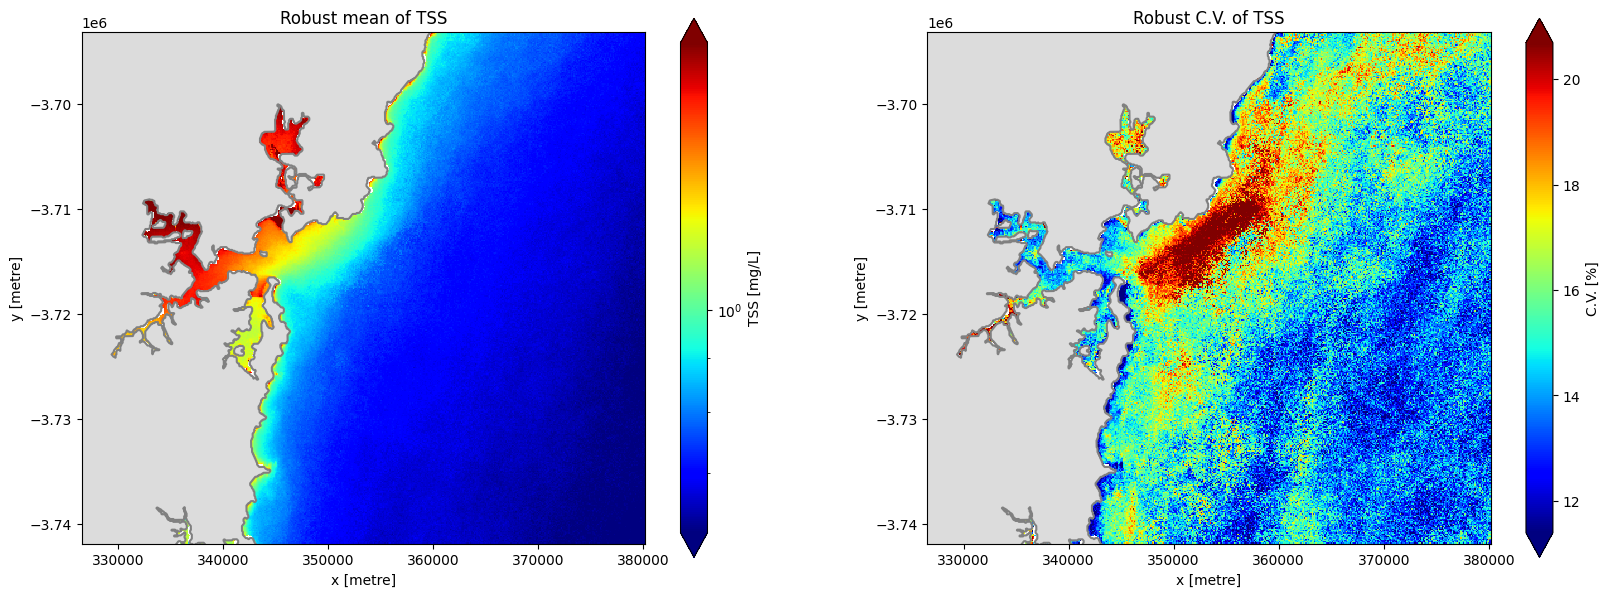

In [19]:
### Plots of results
plt_subs = 4   # spatial subsampling increment
display( HTML(f'<h4>Overall (robust) mean and CV of {WQparam}') )
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,7))

data_wq_stats.sel(robust_stats='mean')[::plt_subs,::plt_subs].plot(robust=True, cmap=cmap, norm=norm, cbar_kwargs={'label':f'{WQparam} [{WQunits}]'}, ax=ax1)
land_mask[::plt_subs,::plt_subs].plot(ax=ax1, add_colorbar=False, add_labels=False, cmap=cmp)
shp_poly.boundary.plot(ax=ax1, color='grey');
ax1.set_title(f"Robust mean of {WQparam}")
ax1.set_aspect('equal','box')

(data_wq_stats.sel(robust_stats='cv')*100.)[::plt_subs,::plt_subs].plot(robust=True, cmap="jet", cbar_kwargs={'label':'C.V. [%]'}, ax=ax2)
land_mask[::plt_subs,::plt_subs].plot(ax=ax2, add_colorbar=False, add_labels=False, cmap=cmp)
shp_poly.boundary.plot(ax=ax2, color='grey');
ax2.set_title(f"Robust C.V. of {WQparam}")
ax2.set_aspect('equal','box')

#### Example using `xr.map_blocks` 

Another, more straightforward approach is to make use of `xr.map_blocks`, which will simply process each data chunk of the (chunked) Dask Xarray in parallel.

Here, the processing function (`robust_stats2`) receives an Xarray DataArray as input, corresponding to one of the data chunks in the processed TSS dataset.

In [20]:
### for use with xr.map_blocks:
def robust_stats2(da, n_valid=10):
    rmean_mat = np.ones((da.sizes['y'],da.sizes['x'])) * np.nan
    rcv_mat = np.ones((da.sizes['y'],da.sizes['x'])) * np.nan
    da_dat = da.values   # IMPORTANT: 'pre-load' data values here and avoid indexing the input DA in loops below!
    for xx in range(da.sizes['x']):
        for yy in range(da.sizes['y']):
            dat = da_dat[:,yy,xx]
            dat = sigma_clip( dat[~np.isnan(dat)], masked=False )   # filter out NaNs and outliers
            if len(dat)>n_valid:   # min 'n_valid' data points
                mm = np.mean(dat)
                rmean_mat[yy,xx] = mm    # mean of data
                rcv_mat[yy,xx] = np.std(dat) / mm    # cv of data
                
    out_ds = xr.Dataset( data_vars=dict( rcv=(["y", "x"], rcv_mat), rmean=(["y", "x"], rmean_mat) ),
                         coords=dict( y=da.y, x=da.x ) )    
    return out_ds

In [21]:
%%time

tmp = data_wq[0,:,:].data
tmp_ds = xr.Dataset( data_vars=dict( rcv=(["y", "x"], tmp), rmean=(["y", "x"], tmp) ),
                     coords=dict( y=data_wq.y, x=data_wq.x ) )

data_wq_stats2 = data_wq.map_blocks( robust_stats2, template=tmp_ds ).persist()
_ = wait(data_wq_stats2)

CPU times: user 29.3 s, sys: 823 ms, total: 30.1 s
Wall time: 56.8 s


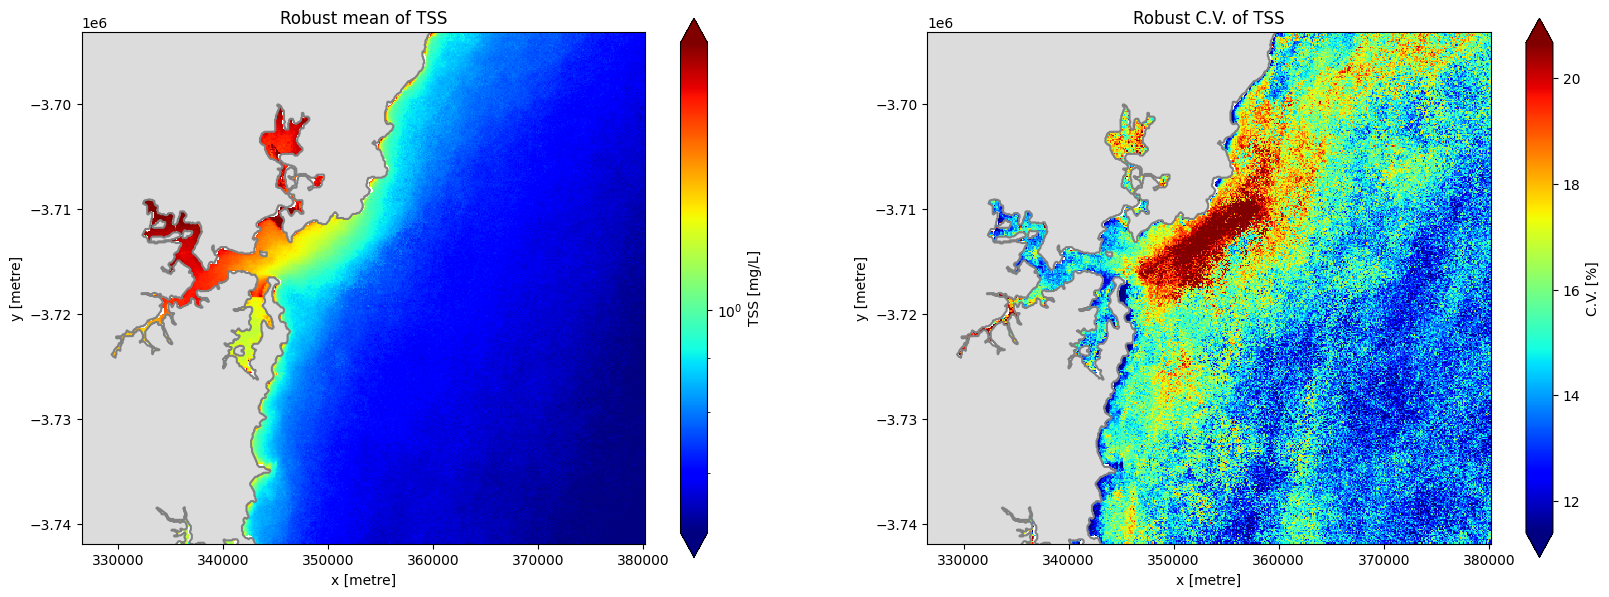

In [22]:
### Plots of results
plt_subs = 4   # spatial subsampling increment
display( HTML(f'<h4>Overall (robust) mean and CV of {WQparam}') )
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,7))

data_wq_stats2['rmean'][::plt_subs,::plt_subs].plot(robust=True, cmap=cmap, norm=norm, cbar_kwargs={'label':f'{WQparam} [{WQunits}]'}, ax=ax1)
land_mask[::plt_subs,::plt_subs].plot(ax=ax1, add_colorbar=False, add_labels=False, cmap=cmp)
shp_poly.boundary.plot(ax=ax1, color='grey');
ax1.set_title(f"Robust mean of {WQparam}")
ax1.set_aspect('equal','box')

(data_wq_stats2['rcv']*100.)[::plt_subs,::plt_subs].plot(robust=True, cmap="jet", cbar_kwargs={'label':'C.V. [%]'}, ax=ax2)
land_mask[::plt_subs,::plt_subs].plot(ax=ax2, add_colorbar=False, add_labels=False, cmap=cmp)
shp_poly.boundary.plot(ax=ax2, color='grey');
ax2.set_title(f"Robust C.V. of {WQparam}")
ax2.set_aspect('equal','box')

## Pixel drills

In [23]:
xy_loc = (350000, -3716000)   # some selected pixel drill location
buf_pix = 10         # buffer around pix drill loc to extract (spatial averaging)

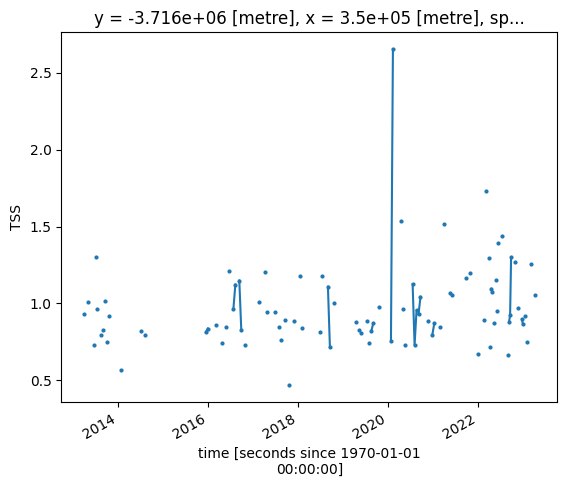

In [24]:
### Single-pixel location, using built-in Xarray methods
TSS_pixdrill = data_wq.sel(x=xy_loc[0], y=xy_loc[1], method='nearest')
TSS_pixdrill.plot(marker='o',markersize=2);

Using some buffer around the pixel of interest to achieve more data points, more robust overview.

In [25]:
### Pix drill loc indices
pixx, pixy = xy_loc
xind = abs(data.x-pixx).argmin().values
yind = abs(data.y-pixy).argmin().values

### Extract pix drill data
yrng = slice(yind-buf_pix, yind+buf_pix)
xrng = slice(xind-buf_pix, xind+buf_pix)
tmp = data_wq.isel(y=yrng, x=xrng)
TSS_pixdrill = tmp.mean(dim=['x','y'], skipna=True).persist()   # WQ spatial average over selected window

### Remove NaN's from extracted time series
tmp = TSS_pixdrill.notnull().compute()
tvec = TSS_pixdrill.time.where(tmp, drop=True)
TSS_pixdrill = TSS_pixdrill.where(tmp, drop=True)

### Linear regression
tt = (tvec.values - tvec.values[0]).astype('timedelta64[D]').astype('int')
tt = sm.add_constant( tt )
lmfit = sm.OLS(TSS_pixdrill.values, tt, missing='drop').fit()

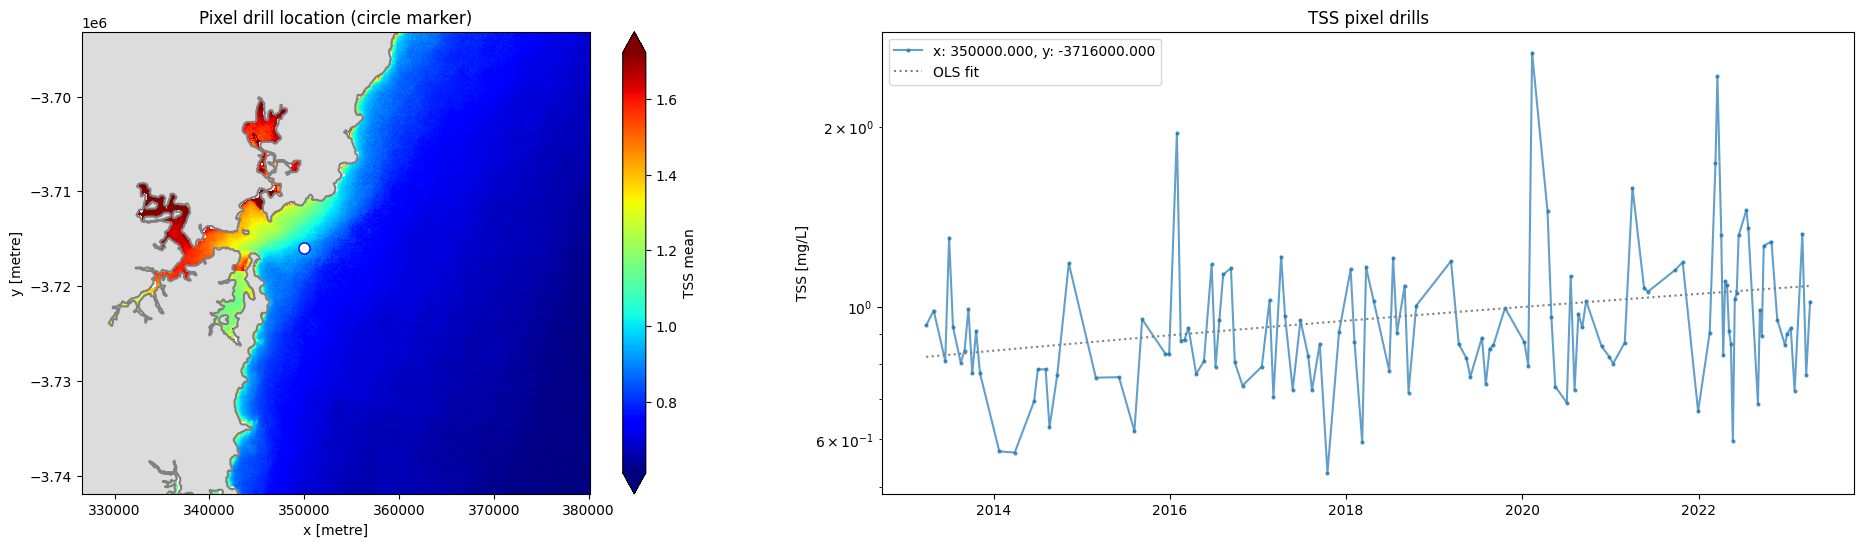

In [26]:
### Plot
fig,(ax0,ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[4,6]}, figsize=(23,6))

data_wq_stats.sel(robust_stats='mean')[::plt_subs,::plt_subs].plot(ax=ax0, robust=True, cmap="jet", cbar_kwargs={'label':'TSS mean'})
ax0.plot( pixx, pixy, marker='o', color='w', markeredgecolor='b', markersize=8 )
land_mask[::plt_subs,::plt_subs].plot(ax=ax0, add_colorbar=False, add_labels=False, cmap=cmp)
shp_poly.boundary.plot(ax=ax0, color='grey');
ax0.set_title('Pixel drill location (circle marker)')
ax0.set_aspect('equal','box')

ax1.plot( tvec, TSS_pixdrill.values, alpha=0.7, marker='o', markersize=2, label=f'x: {pixx:.3f}, y: {pixy:.3f}')
ax1.plot( tvec.values, lmfit.fittedvalues, color='grey', linestyle=':', label='OLS fit')
ax1.legend()
if wq_log_scale: ax1.set_yscale('log')

ax1.set_ylabel(f'{WQparam} [{WQunits}]')
ax1.set_title(f'{WQparam} pixel drills');

In [27]:
### Save to file if needed
pixdrill_DF = pd.DataFrame()
pixdrill_DF[f"{WQparam} ({WQunits}) at ({pixx},{pixy})"] = pd.DataFrame( data=TSS_pixdrill, index=[str(dd)[:10] for dd in TSS_pixdrill.time.values] )
# pixdrill_DF.to_csv(pixdrill_file)   # save to .csv file
pixdrill_DF

TSS (mg/L) at (350000,-3716000)
2013-03-27                         0.929659
2013-04-27                         0.984744
2013-06-14                         0.811431
2013-06-30                         1.303423
2013-07-16                         0.925580
...                                     ...
2023-01-17                         0.920986
2023-02-02                         0.723011
2023-03-06                         1.323999
2023-03-22                         0.769302
2023-04-07                         1.018907

[120 rows x 1 columns]

## Hovmöller plots

A Hovmöller plot depicts the time series of water quality values along a transect in the region of interest, e.g. a horizontal transect line for a specified latitude coordinate. We demonstrate this here by using water quality values averaged monthly (to avoid gaps of missing values in the plots).


In [28]:
trans_lat = -3.715e6  # xy_loc[1]
n_pix_buf = 10

In [29]:
tmp = abs(n_pix_buf*mc_res[1])
stmp = slice(trans_lat-tmp, trans_lat+tmp)   # buffer of n_pix around transect line

tmp = data_wq.sel(y=stmp).mean('y').persist()   # mean over buffer pixels around transect

tmp = tmp.resample(time="M",skipna=True).mean('time',skipna=True).persist()   # monthly averages
_ = wait(tmp)

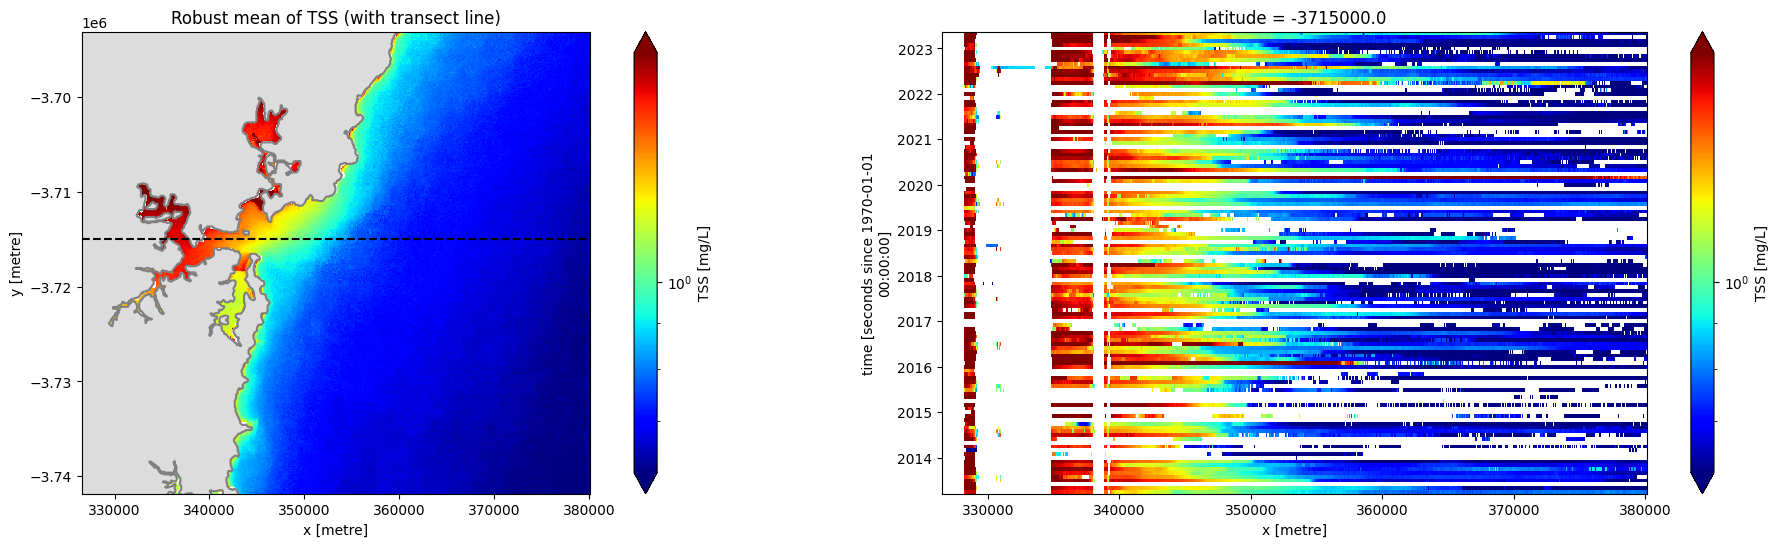

In [30]:
### Hovmöller plots
fig, (ax0,ax1) = plt.subplots( 1, 2, figsize=(25,6) )

data_wq_stats.sel(robust_stats='mean')[::plt_subs,::plt_subs].plot(robust=True, cmap=cmap, norm=norm, cbar_kwargs={'label':f'{WQparam} [{WQunits}]'}, ax=ax0)
land_mask.plot(ax=ax0, add_colorbar=False, add_labels=False, cmap=cmp)
shp_poly.boundary.plot(ax=ax0, color='grey')
ax0.axhline(y=trans_lat, linestyle='--', color='k')
ax0.set_title(f"Robust mean of {WQparam} (with transect line)")
ax0.set_aspect('equal','box')

tmp.plot(robust=True, ax=ax1, cmap=cmap, norm=norm, cbar_kwargs={'label':f'{WQparam} [{WQunits}]'})
ax1.set_title(f"latitude = {trans_lat}");

## Time-of-year means over quarters

Calculate and display maps of (robust) average WQ parameter values for all time series data in 1st quarter, all data in 2nd quarter, etc.


Using a more robust approach...

In [31]:
def robust_mean(dat, min_valid=5):
    dat = sigma_clip( dat[~np.isnan(dat)], masked=False )   # filter out NaNs and outliers
    if len(dat)<min_valid: return np.nan   # min nr of valid data points needed
    return np.mean(dat)

In [32]:
%%time

### Group dataset by quarter of year, and apply robust mean
tmp = data_wq.groupby('time.quarter')
data_wq_mean_month = xr.apply_ufunc( robust_mean, tmp, input_core_dims=[["time"]], 
                                     dask='parallelized', vectorize=True )
data_wq_mean_month = data_wq_mean_month.persist()
_ = wait(data_wq_mean_month)

CPU times: user 41.2 s, sys: 1.36 s, total: 42.5 s
Wall time: 1min 33s


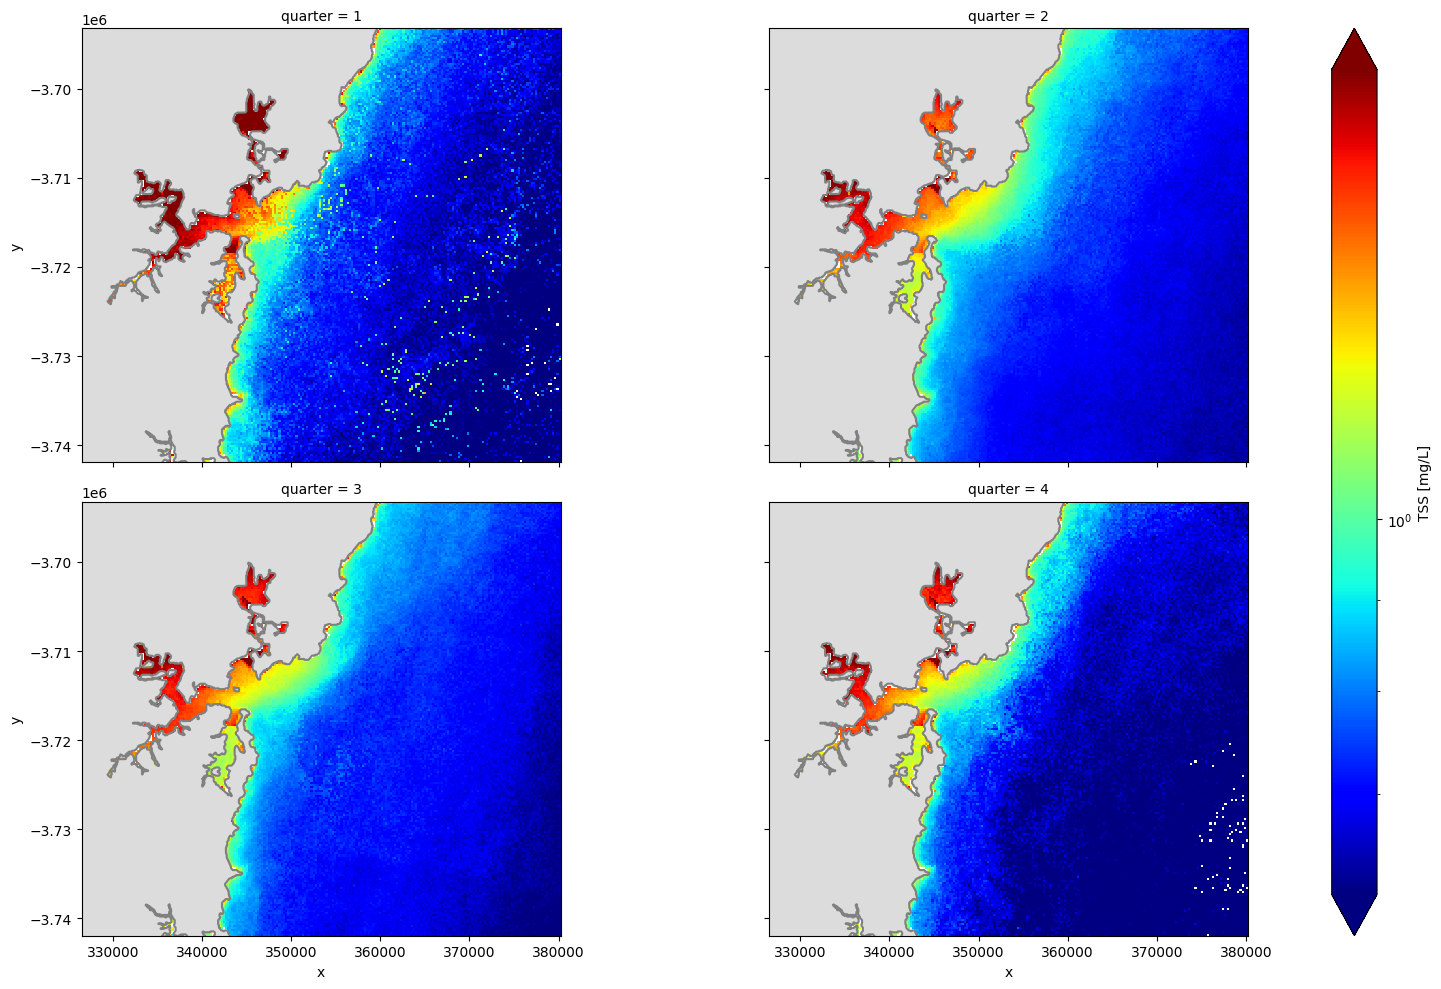

In [33]:
### Plots of results
plt_subs = 8
display( HTML(f'<h4>Quarterly (robust) mean of {WQparam}') )

pp = data_wq_mean_month[:,::plt_subs,::plt_subs].plot( col='quarter', col_wrap=2, figsize=(18,10), robust=True, cmap=cmap, 
                                                       norm=norm, cbar_kwargs={'label':f'{WQparam} [{WQunits}]'} )

for ax in pp.axs.flat:
    ax.set_aspect('equal','box')
    land_mask[::plt_subs,::plt_subs].plot(ax=ax, add_colorbar=False, add_labels=False, cmap=cmp)
    shp_poly.boundary.plot(ax=ax, color='grey')

## Yearly anomalies

Calculate the mean WQ value for each year, then subtract the previously calculated overall mean (for each year) to obtain the yearly WQ anomaly

In [34]:
tmp = data[WQparam].chunk({'time':1}).persist()   # use data with 1-sized time chunks -- needed/better for monthly resampling!

### Remove first and last years if not enough data available
date_obj = date_start.astype(object)
min_year = date_obj.year
if date_obj.month>3: min_year += 1   # discard 1st year if less than 3/4 of data available 

date_obj = date_end.astype(object)
max_year = date_obj.year
if date_obj.month<10: max_year -= 1   # discard last year if less than 3/4 of data available 

tmp = tmp.sel(time=slice(str(min_year), str(max_year))).persist()

In [35]:
%%time

### Apply robust mean to each year
data_wq_mean_yr = xr.apply_ufunc( robust_mean, tmp.resample(time="Y",skipna=True),   # DataArrayResample, grouped over '__resample_dim__'
                                  input_core_dims=[["time"]], dask='parallelized', vectorize=True,
                                  dask_gufunc_kwargs={'allow_rechunk':True})   # rechunk needed as 'tmp' input is chunked along time dim
data_wq_mean_yr = data_wq_mean_yr.rename({'__resample_dim__':'year'})   # artefact of .resample()
data_wq_mean_yr = data_wq_mean_yr.persist()
_ = wait(data_wq_mean_yr)

CPU times: user 17.7 s, sys: 782 ms, total: 18.4 s
Wall time: 2min 42s


In [36]:
data_wq_mean_yr['year'] = data_wq_mean_yr.year.dt.year

data_wq_anom_yr = data_wq_mean_yr - data_wq_stats.sel(robust_stats='mean').chunk(-1)

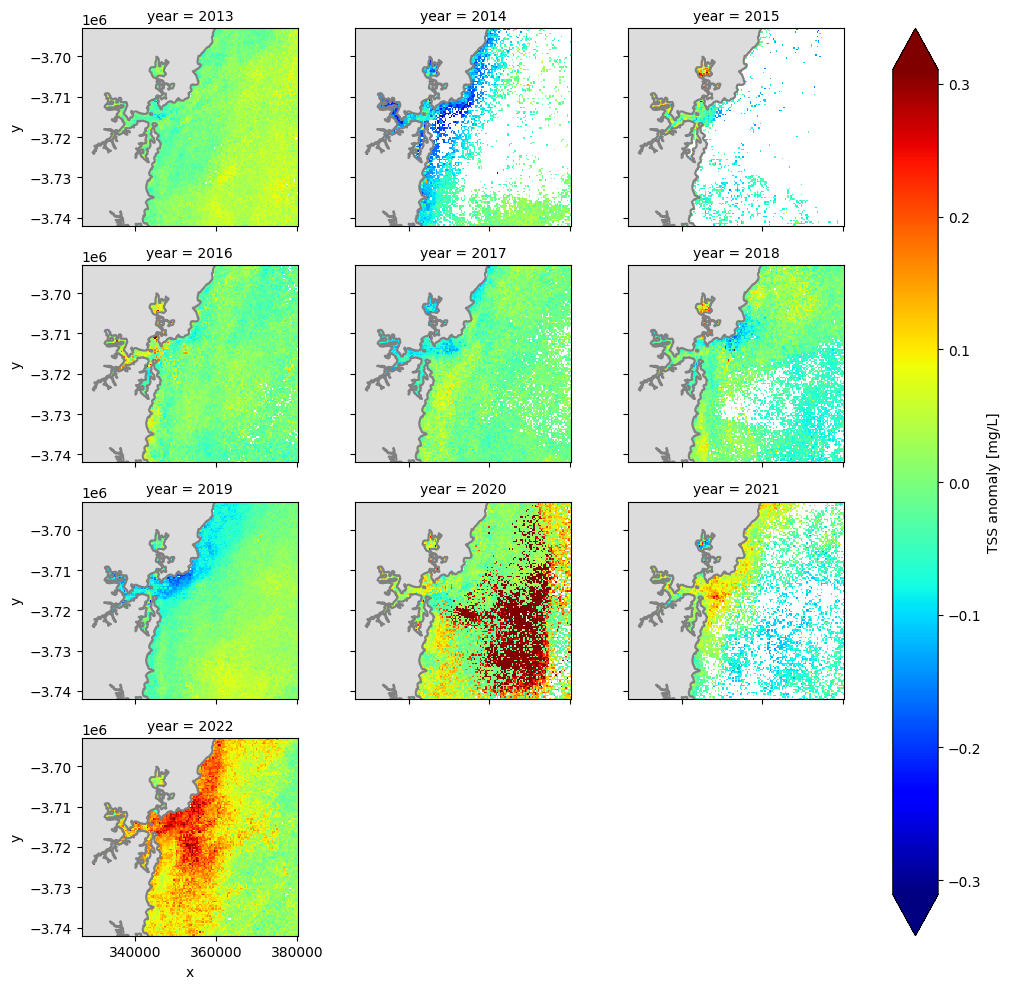

In [37]:
### Plots of results
plt_subs = 12
display( HTML(f'<h4>Yearly anomaly (difference from overall mean) of {WQparam}, over period from {date_start} to {date_end}') )

pp = data_wq_anom_yr[:,::plt_subs,::plt_subs].plot( col='year', col_wrap=3, figsize=(11,10), robust=True, cmap=cmap, 
                                                    cbar_kwargs={'label':f'{WQparam} anomaly [{WQunits}]'} )

for ax in pp.axs.flat:
    ax.set_aspect('equal','box')
    land_mask[::plt_subs,::plt_subs].plot(ax=ax, add_colorbar=False, add_labels=False, cmap=cmp)
    shp_poly.boundary.plot(ax=ax, color='grey')

## (Robust) temporal trend: OLS model

Calculate the (robust) trend of WQ values over time (entire time series). Here using a simple ordinary least squares (OLS) linear regression to fit the trend (with associated p-value of statistical significance).

In [38]:
def OLS_slope(yvec, tvec, min_valid=20):
    # Computes an OLS linear-model regression of yvec values over tvec values.
    # Returns the slope coefficient and p-value.
    
    if not len(yvec)==len(tvec): return np.array([np.nan, np.nan])   # sanity checks
    
    ### Remove NaNs
    notnanind = np.where( ~np.isnan(yvec) )[0]
    yvec = yvec[notnanind]   # filter out NaNs
    tvec = tvec[notnanind]
    if len(yvec)<min_valid: return np.array([np.nan, np.nan])   # min N data points to calculate trend slope
    
    ### Remove outliers
    res = sigma_clip( yvec, masked=True )   # filter out outliers
    yvec = yvec[~res.mask]
    tvec = tvec[~res.mask]
    if len(yvec)<min_valid: return np.array([np.nan, np.nan])   # min N data points to calculate trend slope
    
    ### OLS slope calculation
    tt = sm.add_constant( tvec )
    lmfit = sm.OLS(yvec, tt, missing='drop').fit()
    pval = lmfit.summary2().tables[1]['P>|t|']['x1']   # p-value of slope coefficient
    slope = lmfit.params[1]   # slope of OLS fit

    return np.array([slope, pval])

In [39]:
%%time

### Reduce spatial compute requirements for demo
tmp = data_wq[:,::5,::5].chunk({'time':-1, 'x':16, 'y':16}).persist()
_ = wait(tmp)

### Time vector of the time series for slope fitting
ttmp = tmp.time.values
tvec = np.array(pd.to_datetime(ttmp).year)   # time vector in years

CPU times: user 3.26 s, sys: 40.9 ms, total: 3.3 s
Wall time: 3.37 s


In [40]:
%%time

### Slope + p-value calculations:
data_wq_OLS = xr.apply_ufunc( OLS_slope, tmp, input_core_dims=[["time"]], kwargs={'tvec':tvec}, 
                              dask='parallelized', vectorize=True, 
                              output_core_dims=[['OLS_res']], output_dtypes=[float],
                              dask_gufunc_kwargs={'output_sizes':{'OLS_res':2}} )   # slope + p-val of WQ over time

data_wq_OLS['OLS_res'] = ['slope', 'pval']   # (re)name outputs
data_wq_OLS = data_wq_OLS.persist()
_ = wait(data_wq_OLS)

CPU times: user 6.42 s, sys: 191 ms, total: 6.61 s
Wall time: 52.9 s


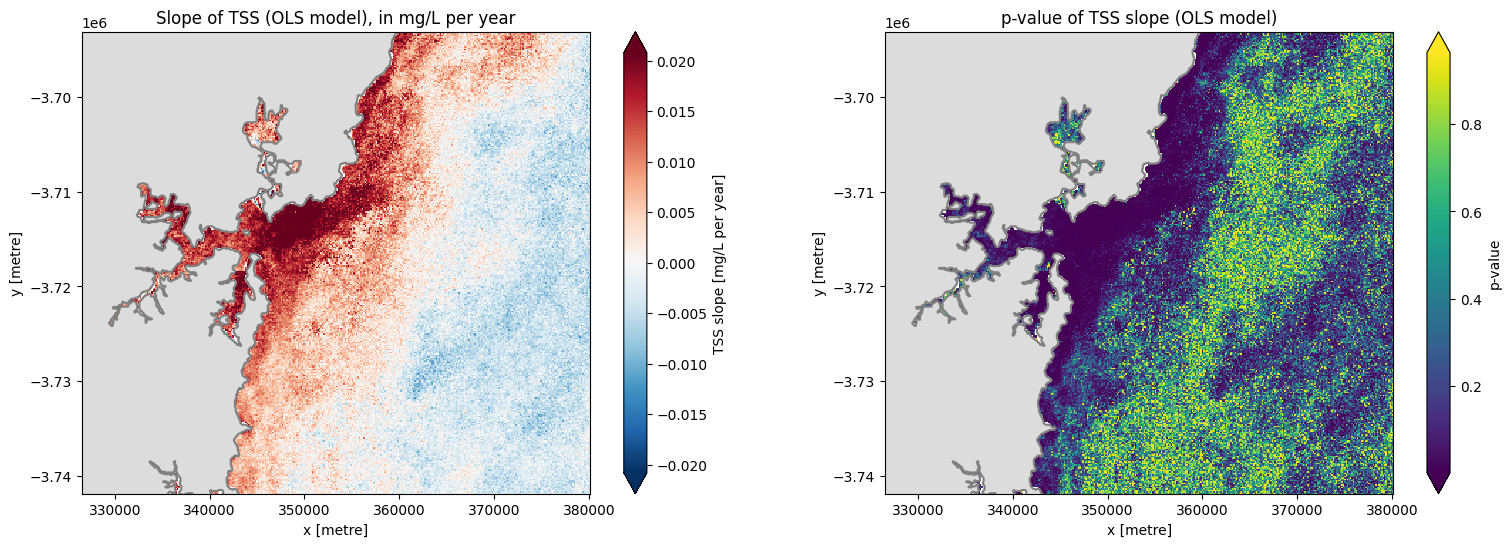

In [41]:
### Plots of results
display( HTML(f'<h4>OLS (robust) slope and <i>p</i>-value of {WQparam}, over period from {date_start} to {date_end}') )

data_wq_slope = data_wq_OLS.sel(OLS_res='slope')   # [units/year]
data_wq_pval = data_wq_OLS.sel(OLS_res='pval')

### Set up colourmap
# cmap1 = 'RdBu_r'   #'coolwarm': centre colour is grey -- 'RdBu_r': centre colour is white
prctile_clip = 5.   # precentile threshold for colour map clipping
vmin = np.nanpercentile(data_wq_slope, prctile_clip/2)   # data_wq_slope.min(skipna=True).values
vmax = np.nanpercentile(data_wq_slope, 100.-prctile_clip/2)   # data_wq_slope.max(skipna=True).values
vmax = np.max(np.abs([vmin,vmax])); vmin = -vmax

### Plots
plt_subs = 2
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(19,6))

data_wq_slope.plot( cbar_kwargs={'label':f'{WQparam} slope [{WQunits} per year]'}, 
                    ax=ax1, cmap=cmap1, vmin=vmin, vmax=vmax )
land_mask[::plt_subs,::plt_subs].plot(ax=ax1, add_colorbar=False, add_labels=False, cmap=cmp)
shp_poly.boundary.plot(ax=ax1, color='grey');
ax1.set_title(f"Slope of {WQparam} (OLS model), in {WQunits} per year")
ax1.set_aspect('equal','box')

data_wq_pval.plot(robust=True, cbar_kwargs={'label':'p-value'}, ax=ax2)
land_mask[::plt_subs,::plt_subs].plot(ax=ax2, add_colorbar=False, add_labels=False, cmap=cmp)
shp_poly.boundary.plot(ax=ax2, color='grey');
ax2.set_title(f"p-value of {WQparam} slope (OLS model)")
ax2.set_aspect('equal','box')

In [42]:
if n_workers is None:  # local Dask cluster
    cluster.close()
    client.shutdown()
else:   # Gateway cluster
    cluster.shutdown()
    client.close()    

In [43]:
### End notebook.